# Malaria Deep Learning Model

# Import Dependencies

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

# Loading Dataset

In [2]:
dataset, dataset_info = tfds.load(
    "malaria",
    with_info=True,
    shuffle_files=True,
    as_supervised=True,
    split=['train'])

In [3]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='C:\\Users\\Timothy Tandt\\tensorflow_datasets\\malaria\\1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection 

In [4]:
for data in dataset[0].take(4):
    print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(106, 121, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [5]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [6]:
def splits(dataset: tf.data.Dataset, TRAIN_RATIO: float, VAL_RATIO: float, TEST_RATIO: float):
    DATASET_SIZE = len(dataset)
    
    train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))

    val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))

    test_dataset = val_test_dataset.skip(int(TEST_RATIO*DATASET_SIZE))
    
    return train_dataset, val_dataset, test_dataset

In [7]:
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

# Dataset Visualization

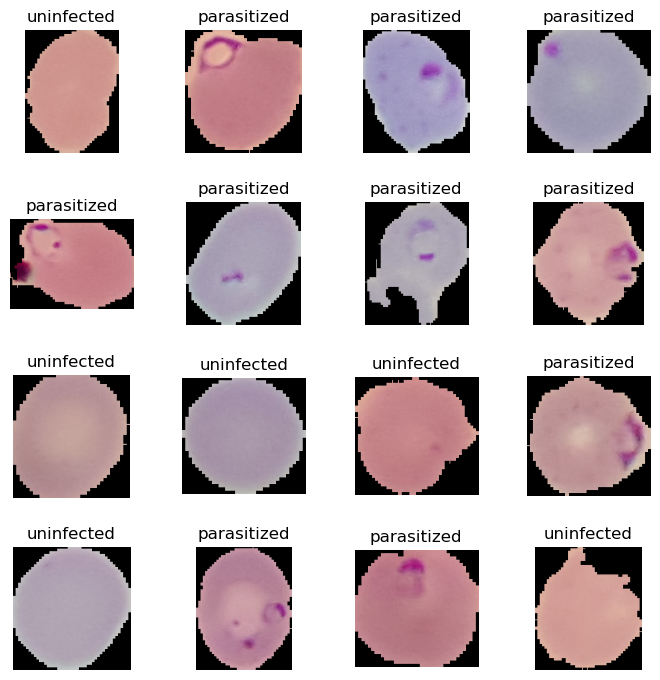

In [8]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

# Iterate over the first 16 elements in the train_dataset
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis("off")
    
# Show the plot
plt.show()

# Data Preprocessing

In [9]:
IM_SIZE = 224
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE)) / 255.0, label

In [10]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [11]:
for image, label in train_dataset.take(1):
    print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [12]:
BATCH_SIZE = 32

In [13]:
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [14]:
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Sequential API

## Limit GPU Memory Usage

In [15]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [16]:
from tensorflow.keras.layers import InputLayer, Conv2D, Dense, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [17]:
model = tf.keras.Sequential()

model.add(InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)))

model.add(Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Flatten())

model.add(Dense(100, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(10, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(1, activation="sigmoid"))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                        

In [19]:
y_true = [0, 1, 0, 0]
y_pred = [0.6, 0.51, 0.94, 0]

bce = BinaryCrossentropy()
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.1007609>

In [20]:
model.compile(optimizer=Adam(learning_rate=0.01), 
              loss=BinaryCrossentropy(),
              metrics="accuracy")

In [21]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20
689/689 [==============================] - 28s 31ms/step - loss: 0.3738 - accuracy: 0.8391 - val_loss: 0.7522 - val_accuracy: 0.8156
Epoch 2/20
689/689 [==============================] - 20s 29ms/step - loss: 0.2263 - accuracy: 0.9212 - val_loss: 1.5597 - val_accuracy: 0.5554
Epoch 3/20
689/689 [==============================] - 19s 28ms/step - loss: 0.2160 - accuracy: 0.9247 - val_loss: 0.1893 - val_accuracy: 0.9401
Epoch 4/20
689/689 [==============================] - 19s 28ms/step - loss: 0.1819 - accuracy: 0.9359 - val_loss: 0.2022 - val_accuracy: 0.9332
Epoch 5/20
689/689 [==============================] - 20s 29ms/step - loss: 0.1817 - accuracy: 0.9382 - val_loss: 0.3177 - val_accuracy: 0.9354
Epoch 6/20
689/689 [==============================] - 19s 28ms/step - loss: 0.1798 - accuracy: 0.9381 - val_loss: 0.2338 - val_accuracy: 0.9350
Epoch 7/20
689/689 [==============================] - 18s 27ms/step - loss: 0.1513 - accuracy: 0.9502 - val_loss: 0.2817 - val_accuracy:

### 6. Plot out the performance

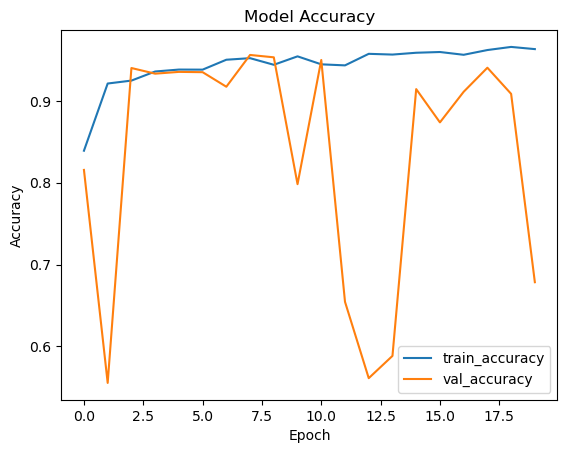

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history["val_accuracy"])

plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Model Evaluation and Testing

In [23]:
print(test_dataset, end='\n\n')
print(train_dataset)

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [24]:
test_dataset = test_dataset.batch(1)
test_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [25]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 10s 3ms/step - loss: 1.8856 - accuracy: 0.6899


[1.8855900764465332, 0.6898803114891052]

In [26]:
model_prediction = model.predict(test_dataset.take(1))
model_prediction

array([[0.00837578]], dtype=float32)

In [27]:
result = model_prediction[0][0]
result

0.0083757825

In [28]:
def parasite_or_not(x):
    if (x < 0.5):
        return 'Parasatize'
    return 'Uninfected'

In [29]:
parasite_or_not(result)

'Parasatize'

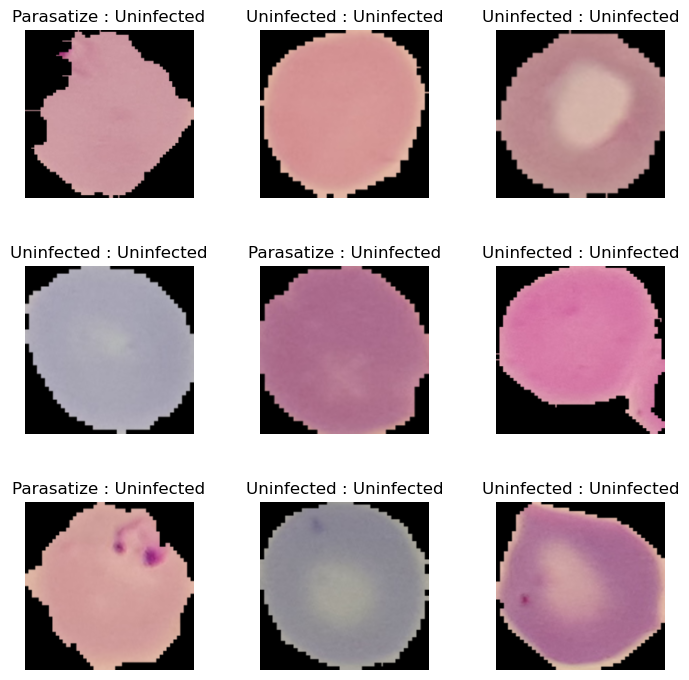

In [30]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

for i, (image, label) in enumerate(test_dataset.take(9)):
    
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0])
    
    title = f"{parasite_or_not(label.numpy()[0])} : {parasite_or_not(model.predict(image)[0][0])}"
    plt.title(title)
    
    plt.axis("off")

# Loading and Saving

In [31]:
import os

In [32]:
current_directory = os.getcwd()
saved_path = os.path.join(current_directory, "model.h5")

In [33]:
model.save(saved_path)

In [34]:
loaded_model = tf.keras.models.load_model(saved_path)
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                        

# Functional API

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import InputLayer, Conv2D, Dense, MaxPool2D, Flatten, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [21]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name="Input Image")

In [22]:
x = Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu")(func_input)

x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)
x = Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu")(x)

x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Flatten()(x)

x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation="relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

In [23]:
lenet_model_func = Model(func_input, func_output, name="Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     

In [24]:
lenet_model_func.compile(optimizer=Adam(learning_rate=0.01),
                    loss=BinaryCrossentropy(),
                    metrics="accuracy")

In [25]:
history = lenet_model_func.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

Epoch 1/5
689/689 [==============================] - 22s 28ms/step - loss: 0.4230 - accuracy: 0.8074 - val_loss: 0.7355 - val_accuracy: 0.7325
Epoch 2/5
689/689 [==============================] - 18s 27ms/step - loss: 0.2452 - accuracy: 0.9090 - val_loss: 0.2012 - val_accuracy: 0.9321
Epoch 3/5
689/689 [==============================] - 18s 26ms/step - loss: 0.2115 - accuracy: 0.9230 - val_loss: 0.2062 - val_accuracy: 0.9383
Epoch 4/5
689/689 [==============================] - 18s 26ms/step - loss: 0.1781 - accuracy: 0.9385 - val_loss: 0.3802 - val_accuracy: 0.7967
Epoch 5/5
689/689 [==============================] - 18s 26ms/step - loss: 0.1671 - accuracy: 0.9415 - val_loss: 0.2860 - val_accuracy: 0.9354


# Feature Extractor

In [26]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name="Input Image")

In [27]:
x = Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu")(func_input)

x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)
x = Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu")(x)

x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)

In [28]:
feature_extractor_model = Model(func_input, output, name="Feature_Extractor")
feature_extractor_model.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_4 (Batc  (None, 222, 222, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_5 (Batc  (None, 109, 109, 16

# Callable Model

In [29]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name="Input Image")

In [30]:
x = feature_extractor_model(func_input)

x = Flatten()(x)

x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation="relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

In [31]:
lenet_model_func = Model(func_input, func_output, name="Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Feature_Extractor (Function  (None, 54, 54, 16)       1136      
 al)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_6 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 10)                

# Model Subclassing

In [17]:
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model

In [33]:
class FeatureExtractor(Model):
    def __init__(self, filters: int, kernel_size: int, strides: int, padding: str, activation: str, pool_size: int):
        super(FeatureExtractor, self).__init__()
        
        self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_1 = BatchNormalization()
        self.pool_1 = MaxPool2D(pool_size=pool_size, strides=2*strides)
        
        self.conv_2 = Conv2D(filters=filters*2, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
        self.batch_2 = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=pool_size, strides=2*strides)
        
    def call(self, x, training):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.pool_1(x)
        
        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.pool_2(x)
        
        return x
    
feature_sub_classed = FeatureExtractor(filters=8, kernel_size=3, strides=1, padding="valid", activation="relu", pool_size=2)

In [34]:
class LenetModel(Model):
    def __init__(self):
        super(LenetModel, self).__init__()
        
        self.feature_extractor = FeatureExtractor(filters=8, kernel_size=3, strides=1, padding="valid", activation="relu", pool_size=2)

        self.flatten = Flatten()
        
        self.dense_1 = Dense(100, activation="relu")
        self.batch_1 = BatchNormalization()
        
        self.dense_2 = Dense(10, activation="relu")
        self.batch_2 = BatchNormalization()
        
        self.dense_3 = Dense(1, activation="sigmoid")
        
    def call(self, x, training):
        x = self.feature_extractor(x)
        
        x = self.flatten(x)
        
        x = self.dense_1(x)
        x = self.batch_1(x)
        
        x = self.dense_2(x)
        x = self.batch_2(x)
        
        x = self.dense_3(x)
        
        return x

lenet_sub_classed = LenetModel()

In [35]:
func_input = Input(shape=(IM_SIZE, IM_SIZE, 3), name="Input Image")

x = feature_sub_classed(func_input)

x = Flatten()(x)

x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation="relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name="Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (FeatureE  (None, 54, 54, 16)       1488      
 xtractor)                                                       
                                                                 
 flatten_3 (Flatten)         (None, 46656)             0         
                                                                 
 dense_9 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_14 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            (None, 10)                

In [36]:
lenet_sub_classed.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [ ]:
lenet_sub_classed(tf.zeros([1, IM_SIZE, IM_SIZE, 3]))
lenet_sub_classed.summary()

In [ ]:
lenet_sub_classed.compile(optimizer=Adam(learning_rate=0.01),
                    loss=BinaryCrossentropy(),
                    metrics="accuracy")

In [ ]:
history = lenet_sub_classed.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

# Custom Layers

In [42]:
class CustomDense(Layer):
    def __init__(self, output_units: int, activation: bool):
        super(CustomDense, self).__init__()
        
        self.activation = activation
        self.output_units = output_units
    
    def build(self, input_features_shape):
        # B,F
        n_rows = input_features_shape[-1]
        
        # w = weights, b = biases
        self.w = self.add_weight(shape=(n_rows, self.output_units), trainable = True, initializer="random_normal")
        self.b = self.add_weight(shape=(self.output_units,), trainable = True, initializer="random_normal")
        
    def call(self, input_features):
        
        pre_output = tf.matmul(input_features, self.w) + self.b
        
        if self.activation == "relu":
            return tf.nn.relu(pre_output)
        
        if self.activation == "sigmoid":
            return tf.math.sigmoid(pre_output)
        else:
            return pre_output

In [18]:
lenet_custom_model = tf.keras.Sequential()

lenet_custom_model.add(InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)))

lenet_custom_model.add(Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu"))
lenet_custom_model.add(BatchNormalization())
lenet_custom_model.add(MaxPool2D(pool_size=2, strides=2))

lenet_custom_model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu"))
lenet_custom_model.add(BatchNormalization())
lenet_custom_model.add(MaxPool2D(pool_size=2, strides=2))

lenet_custom_model.add(Flatten())

lenet_custom_model.add(CustomDense(100, activation="relu"))
lenet_custom_model.add(BatchNormalization())
lenet_custom_model.add(CustomDense(10, activation="relu"))
lenet_custom_model.add(BatchNormalization())
lenet_custom_model.add(CustomDense(1, activation="sigmoid"))

lenet_custom_model.summary()

NameError: name 'CustomDense' is not defined

In [ ]:
lenet_custom_model.compile(optimizer=Adam(learning_rate=0.01),
                    loss=BinaryCrossentropy(),
                    metrics="accuracy")

In [ ]:
history = lenet_custom_model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

# Metrics

In [17]:
from tensorflow.keras.metrics import Accuracy, FalseNegatives, FalsePositives, TruePositives, TrueNegatives, Precision, Recall, BinaryAccuracy, AUC
from tensorflow.keras.layers import InputLayer, Conv2D, Dense, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [18]:
lenet_model = tf.keras.Sequential()

lenet_model.add(InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)))

lenet_model.add(Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu"))
lenet_model.add(BatchNormalization())
lenet_model.add(MaxPool2D(pool_size=2, strides=2))

lenet_model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu"))
lenet_model.add(BatchNormalization())
lenet_model.add(MaxPool2D(pool_size=2, strides=2))

lenet_model.add(Flatten())

lenet_model.add(Dense(100, activation="relu"))
lenet_model.add(BatchNormalization())
lenet_model.add(Dense(10, activation="relu"))
lenet_model.add(BatchNormalization())
lenet_model.add(Dense(1, activation="sigmoid"))

lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                        

In [19]:
metrics = [
    TruePositives(name="True Positives"),
    TrueNegatives(name="True Negatives"),
    FalseNegatives(name="False Negatives"),
    FalsePositives(name="False Positives"),
    BinaryAccuracy(name="Binary Accuracy"),
    Precision(name="Precision"),
    Recall(name="Recall"),
    AUC(name="AUC")
]

In [20]:
lenet_model.compile(optimizer=Adam(learning_rate=0.01),
                   loss=BinaryCrossentropy(),
                   metrics=metrics)

In [22]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

Epoch 1/5
689/689 [==============================] - 30s 35ms/step - loss: 0.2787 - True Positives: 10062.0000 - True Negatives: 9677.0000 - False Negatives: 961.0000 - False Positives: 1346.0000 - Binary Accuracy: 0.8954 - Precision: 0.8820 - Recall: 0.9128 - AUC: 0.9499 - val_loss: 0.2305 - val_True Positives: 1393.0000 - val_True Negatives: 1150.0000 - val_False Negatives: 20.0000 - val_False Positives: 192.0000 - val_Binary Accuracy: 0.9230 - val_Precision: 0.8789 - val_Recall: 0.9858 - val_AUC: 0.9663
Epoch 2/5
689/689 [==============================] - 23s 33ms/step - loss: 0.1909 - True Positives: 10487.0000 - True Negatives: 10179.0000 - False Negatives: 535.0000 - False Positives: 845.0000 - Binary Accuracy: 0.9374 - Precision: 0.9254 - Recall: 0.9515 - AUC: 0.9729 - val_loss: 0.1788 - val_True Positives: 1322.0000 - val_True Negatives: 1296.0000 - val_False Negatives: 51.0000 - val_False Positives: 86.0000 - val_Binary Accuracy: 0.9503 - val_Precision: 0.9389 - val_Recall: 0.

In [23]:
test_dataset = test_dataset.batch(1)
test_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [24]:
lenet_model.evaluate(test_dataset)

2757/2757 [==============================] - 19s 6ms/step - loss: 0.3397 - True Positives: 1335.0000 - True Negatives: 1228.0000 - False Negatives: 27.0000 - False Positives: 167.0000 - Binary Accuracy: 0.9296 - Precision: 0.8888 - Recall: 0.9802 - AUC: 0.9631


[0.3397105634212494,
 1335.0,
 1228.0,
 27.0,
 167.0,
 0.9296336770057678,
 0.8888149261474609,
 0.9801762104034424,
 0.9631217122077942]

# Visualizing Confusion Matrix

In [25]:
import sklearn
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [26]:
labels = []
input = []

for x, y in test_dataset.as_numpy_iterator():
    labels.append(y)
    input.append(x)

In [27]:
print(labels)

[array([0], dtype=int64), array([0], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([0], dtype=int64), array([1], dtype=int64), array([0], dtype=int64), array([1], dtype=int64), array([0], dtype=int64), array([1], dtype=int64), array([0], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([1], dtype=int64), array([0], dtype=int64), array([1], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([1], dtype=int64), array([0], dtype=int64), array([1], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([0], dtype=int64), array([1], dtype=int64),

In [28]:
print(np.array(input).shape)
print(np.array(input)[:,0,...].shape)

(2757, 1, 224, 224, 3)
(2757, 224, 224, 3)


In [29]:
predicted = lenet_model.predict(np.array(input)[:,0,...])

In [30]:
print(predicted.shape)

(2757, 1)


In [31]:
print(predicted[:,0].shape)
print(predicted[:,0])

(2757,)
[3.7503490e-04 9.9956924e-01 9.9979049e-01 ... 5.1443058e-01 9.9989057e-01
 9.9991977e-01]


[[1288   93]
 [ 117 1259]]


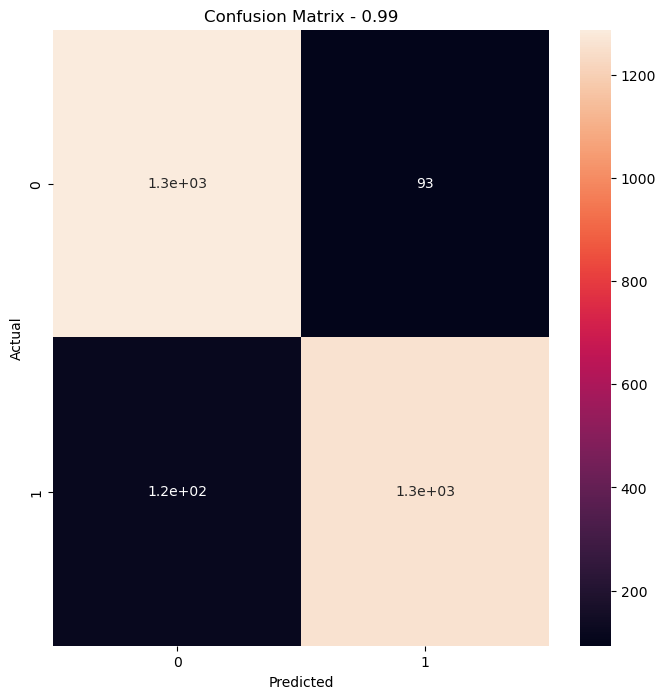

In [38]:
# Choosing an efficient threshold

threshold = 0.99 # chosen to minimize False Positives using the ROC Plot Below

cm = confusion_matrix(labels, predicted > threshold)
print(cm)

plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# TN, FP
# FN, TP

# ROC PLOTS

In [33]:
from sklearn.metrics import confusion_matrix, roc_curve

In [34]:
fp, tp, thresholds = roc_curve(labels, predicted)
print(len(fp), len(tp), len(thresholds))

513 513 513


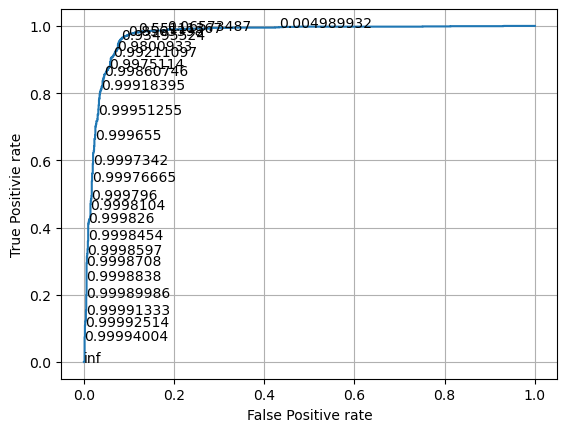

In [35]:
         # x, y
plt.plot(fp, tp)
plt.xlabel("False Positive rate")
plt.ylabel("True Positivie rate")

plt.grid()

skip = 20
for i in range(0, len(thresholds), skip):
    plt.text(fp[i], tp[i], thresholds[i])

plt.show()

# Can choose a threshold here that suits the model the best

# Callbacks

In [37]:
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler

In [22]:
from tensorflow.keras.metrics import Accuracy, FalseNegatives, FalsePositives, TruePositives, TrueNegatives, Precision, Recall, BinaryAccuracy, AUC
from tensorflow.keras.layers import InputLayer, Conv2D, Dense, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [23]:
class LossCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        print("\n For Epoch Number {} the model has a loss of {}".format(epoch+1, logs["loss"]))
        
    def on_batch_end(self, batch, logs):
        print("\n For Batch Number {} the model has a loss of {}".format(batch+1, logs["loss"]))

## CSV Logger

In [24]:
csv_callback = CSVLogger('logs.csv', separator=',', append=True)

## Early Stopping

es_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
)

## Learning Rate Scheduler

In [50]:
def scheduler(epoch, lr):
    if epoch <= 3:
        return lr
    return lr * tf.math.exp(-0.1)

In [51]:
scheduler_callback = LearningRateScheduler(scheduler, verbose=1)

## Model Checkpointing

## Model Training

In [52]:
lenet_model = tf.keras.Sequential()

lenet_model.add(InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)))

lenet_model.add(Conv2D(filters=6, kernel_size=3, strides=1, padding="valid", activation="relu"))
lenet_model.add(BatchNormalization())
lenet_model.add(MaxPool2D(pool_size=2, strides=2))

lenet_model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding="valid", activation="relu"))
lenet_model.add(BatchNormalization())
lenet_model.add(MaxPool2D(pool_size=2, strides=2))

lenet_model.add(Flatten())

lenet_model.add(Dense(100, activation="relu"))
lenet_model.add(BatchNormalization())
lenet_model.add(Dense(10, activation="relu"))
lenet_model.add(BatchNormalization())
lenet_model.add(Dense(1, activation="sigmoid"))

# lenet_model.summary()

In [53]:
metrics = [
    TruePositives(name="True Positives"),
    TrueNegatives(name="True Negatives"),
    FalseNegatives(name="False Negatives"),
    FalsePositives(name="False Positives"),
    BinaryAccuracy(name="Binary Accuracy"),
    Precision(name="Precision"),
    Recall(name="Recall"),
    AUC(name="AUC")
]

In [54]:
callbacks = [
    # LossCallback(),
    csv_callback,
    es_callback,
    scheduler_callback,
]

In [55]:
lenet_model.compile(optimizer=Adam(learning_rate=0.01),
                   loss=BinaryCrossentropy(),
                   metrics=metrics)

In [56]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1, callbacks=callbacks)


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/5
689/689 [==============================] - 24s 33ms/step - loss: 0.4934 - True Positives: 8206.0000 - True Negatives: 8510.0000 - False Negatives: 2823.0000 - False Positives: 2507.0000 - Binary Accuracy: 0.7582 - Precision: 0.7660 - Recall: 0.7440 - AUC: 0.8390 - val_loss: 2.6330 - val_True Positives: 1389.0000 - val_True Negatives: 202.0000 - val_False Negatives: 11.0000 - val_False Positives: 1153.0000 - val_Binary Accuracy: 0.5775 - val_Precision: 0.5464 - val_Recall: 0.9921 - val_AUC: 0.7121 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/5
689/689 [==============================] - 21s 31ms/step - loss: 0.2215 - True Positives: 10237.0000 - True Negatives: 10076.0000 - False Negatives: 789.0000 - False Positives: 944.0000 - Binary Accuracy: 0.9214 - Precision: 0.9156 - Recall: 0.9284 - AUC: 0.9666 - val_loss: 0.2646 - val_True Positives: 137